In [7]:
# -*- coding: utf-8 -*-

import os
import shutil
import time
import random
from pathlib import Path
import math

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# New imports for EfficientNetV2
from tensorflow.keras.applications import EfficientNetV2M
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as efficientnet_v2_preprocess
from tensorflow.keras.utils import plot_model

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow version:", tf.__version__)
print("Available GPUs:", tf.config.list_physical_devices('GPU'))
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

# ---------------------------
# CONFIGURATION
# ---------------------------

# Define your data paths (adjust these if needed)
# Assuming 'Dataset' is a folder in the same location as your notebook or on E:
DATA_ROOT = Path('./Dataset') 
ORG_DIR = Path('./lsun_organized_v2m') # Directory for organized train/val/test splits

# HYPERPARAMETERS
IMG_SIZE = 384 # Increased size for EfficientNetV2M - Standard is 384 for M-variant
BATCH_SIZE = 16 # Adjusted to 16 for better memory usage with larger images/model
BATCH_SIZE_STAGE2 = 8 # NEW: Halve the batch size for Fine-Tuning
EPOCHS_STAGE_1 = 15 # Shorter first stage
EPOCHS_STAGE_2 = 50 # Longer second stage (Fine-tuning)
MAX_IMAGES_PER_CLASS = 30000 # Use the full dataset

# Your specific 4 classes
EXPECTED_CATEGORIES = ['bedroom', 'dining_room', 'kitchen', 'living_room']
VALID_IMAGE_EXTS = ['.jpg', '.jpeg', '.png', '.webp']

NUM_CLASSES = len(EXPECTED_CATEGORIES)

# Check for GPU
if not tf.config.list_physical_devices('GPU'):
    print("\n⚠️  WARNING: No GPU detected. Training will be extremely slow on CPU.")

TensorFlow version: 2.10.1
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available: 1


In [2]:
# ---------------------------
# DATA VALIDATION
# ---------------------------

def count_images_in_dir(p):
    """Counts files with valid image extensions recursively."""
    if not p.exists() or not p.is_dir():
        return 0
    cnt = 0
    for ext in VALID_IMAGE_EXTS:
        cnt += len(list(p.rglob(f'*{ext}')))
    return cnt

def validate_and_diagnose_data(data_root=DATA_ROOT, expected_categories=EXPECTED_CATEGORIES):
    """Complete data validation before training."""
    print("\n" + "="*80)
    print("DATA VALIDATION & DIAGNOSIS")
    print("="*80 + "\n")
    
    # Check raw data
    print(f"1. Checking RAW data ({data_root})...")
    if not data_root.exists():
        print(f"❌ ERROR: {data_root} not found! Check your drive letter or path.")
        return False
    
    raw_stats = {}
    raw_issues = []
    
    for category in expected_categories:
        cat_path = data_root / category
        if not cat_path.exists():
            raw_issues.append(f"Missing folder: {category}")
            continue
        
        img_count = count_images_in_dir(cat_path)
        raw_stats[category] = img_count
        
        if img_count < 100:
            raw_issues.append(f"'{category}' has only {img_count} images (need 100+)")
        else:
            print(f"  ✓ {category:18}: {img_count:,} images found")
    
    if raw_issues:
        print("\n❌ RAW DATA ISSUES:")
        for issue in raw_issues:
            print(f"  - {issue}")
        return False
    
    # Check class balance
    total_raw = sum(raw_stats.values())
    max_count = max(raw_stats.values())
    min_count = min(raw_stats.values())
    imbalance = max_count / min_count if min_count > 0 else float('inf')
    
    print(f"\n✓ Raw data OK: {len(raw_stats)} categories, {total_raw:,} total images")
    
    if imbalance > 2.0:
        print(f"⚠️  WARNING: Class imbalance detected (ratio: {imbalance:.2f}x).")
    else:
        print(f"✓ Classes are well-balanced (ratio: {imbalance:.2f}x)")
    
    print("="*80 + "\n")
    return True

# ---------------------------
# ORGANIZE DATA (Split)
# ---------------------------

def organize_dataset_structure(source_dir, target_dir, max_images_per_class=MAX_IMAGES_PER_CLASS):
    """Build train/val/test folders from raw data."""
    source_dir = Path(source_dir)
    target_dir = Path(target_dir)
    
    # Check if already organized and skip if files exist
    if target_dir.exists():
        splits = ['train', 'val', 'test']
        has_all_data = True
        for split in splits:
            for category in EXPECTED_CATEGORIES:
                if count_images_in_dir(target_dir / split / category) == 0:
                    has_all_data = False
                    break
        
        if has_all_data:
            print(f"✓ Organized data exists at: {target_dir}")
            print("  Skipping reorganization (delete folder to reorganize)\n")
            return str(target_dir)
    
    print(f"\nOrganizing dataset...")
    print(f"Source: {source_dir}")
    print(f"Target: {target_dir}\n")
    
    # Create the main split directories
    target_dir.mkdir(parents=True, exist_ok=True)
    for split in ['train', 'val', 'test']:
        (target_dir / split).mkdir(parents=True, exist_ok=True)

    for category in EXPECTED_CATEGORIES:
        cat_src = source_dir / category
        
        # Gather images (with confirmation of JPG format)
        image_files = []
        for ext in VALID_IMAGE_EXTS:
            image_files.extend(list(cat_src.rglob(f'*{ext}')))
        
        print(f"Processing '{category}': found {len(image_files):,} images")
        
        if len(image_files) < 10:
            print(f"  ⚠️  Too few images, skipping (need at least 10)")
            continue
        
        # Limit images to the specified max
        if len(image_files) > max_images_per_class:
            # We shuffle and sample to ensure fairness across the 30k images
            image_files = random.sample(image_files, max_images_per_class)
            print(f"  Limited to {max_images_per_class:,} images")
        
        # Split data: 70% train, 15% val, 15% test
        # First split 30% out for val/test
        train_files, temp_files = train_test_split(image_files, test_size=0.3, random_state=SEED, shuffle=True)
        # Second split temp_files 50/50 for val and test (0.3 * 0.5 = 0.15)
        val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=SEED, shuffle=True)
        
        # Copy files
        splits_dict = {'train': train_files, 'val': val_files, 'test': test_files}
        for split_name, files in splits_dict.items():
            split_cat_dir = target_dir / split_name / category
            split_cat_dir.mkdir(parents=True, exist_ok=True)
            for i, src in enumerate(files):
                # Using unique naming convention to avoid collisions
                dst = split_cat_dir / f"{category}_{i}{src.suffix}"
                # Using shutil.copy2 for better metadata preservation
                shutil.copy2(src, dst)
        
        print(f"  ✓ train={len(train_files):,}, val={len(val_files):,}, test={len(test_files):,}")
    
    print(f"\n✓ Organization complete! Total images processed: {len(image_files)*len(EXPECTED_CATEGORIES):,}\n")
    return str(target_dir)

# ---------------------------
# EXECUTION (Run this block)
# ---------------------------

# Step A: Validate the raw data existence
if validate_and_diagnose_data():
    # Step B: Organize the dataset into train/val/test splits
    organized_data_path = organize_dataset_structure(DATA_ROOT, ORG_DIR)
else:
    organized_data_path = None
    print("\nAborting pipeline due to data validation errors.")


DATA VALIDATION & DIAGNOSIS

1. Checking RAW data (Dataset)...
  ✓ bedroom           : 30,000 images found
  ✓ dining_room       : 30,000 images found
  ✓ kitchen           : 30,000 images found
  ✓ living_room       : 30,000 images found

✓ Raw data OK: 4 categories, 120,000 total images
✓ Classes are well-balanced (ratio: 1.00x)


Organizing dataset...
Source: Dataset
Target: lsun_organized_v2m

Processing 'bedroom': found 30,000 images
  ✓ train=21,000, val=4,500, test=4,500
Processing 'dining_room': found 30,000 images
  ✓ train=21,000, val=4,500, test=4,500
Processing 'kitchen': found 30,000 images
  ✓ train=21,000, val=4,500, test=4,500
Processing 'living_room': found 30,000 images
  ✓ train=21,000, val=4,500, test=4,500

✓ Organization complete! Total images processed: 120,000



In [3]:
# ---------------------------
# DATA GENERATORS
# ---------------------------

def create_data_generators(data_dir, img_size=IMG_SIZE, batch_size=BATCH_SIZE):
    """
    Data generators for transfer learning models (EfficientNetV2M).
    - NO rescaling (ImageDataGenerator handles pixel values 0-255).
    - Model-specific preprocessing will be handled by a dedicated Keras layer later.
    """
    
    # 1. Training Generator (with Augmentation)
    # Augmentation helps the model generalize better by seeing varied versions of images.
    train_datagen = ImageDataGenerator(
        rotation_range=15,             # Rotate images up to 15 degrees
        width_shift_range=0.1,         # Shift images horizontally
        height_shift_range=0.1,        # Shift images vertically
        shear_range=0.1,               # Shear transformation
        zoom_range=0.1,                # Zoom in/out
        horizontal_flip=True,          # Flip images horizontally (common for scenes)
        fill_mode='nearest'            # Strategy for filling in missing pixels after transformation
    )
    
    # 2. Validation/Test Generator (No Augmentation)
    test_datagen = ImageDataGenerator() # Only used to load data sequentially

    train_dir = os.path.join(data_dir, 'train')
    val_dir = os.path.join(data_dir, 'val')
    test_dir = os.path.join(data_dir, 'test')

    # Flow from directory setups
    train_generator = train_datagen.flow_from_directory(
        train_dir, target_size=(img_size, img_size), batch_size=batch_size,
        class_mode='categorical', shuffle=True, seed=SEED
    )

    val_generator = test_datagen.flow_from_directory(
        val_dir, target_size=(img_size, img_size), batch_size=batch_size,
        class_mode='categorical', shuffle=False
    )

    test_generator = test_datagen.flow_from_directory(
        test_dir, target_size=(img_size, img_size), batch_size=batch_size,
        class_mode='categorical', shuffle=False
    )

    print(f"\nData generators created:")
    print(f"  Train: {train_generator.samples:,} samples")
    print(f"  Val:   {val_generator.samples:,} samples")
    print(f"  Test:  {test_generator.samples:,} samples")
    print(f"  Number of classes: {len(train_generator.class_indices)}")
    
    return train_generator, val_generator, test_generator, train_generator.class_indices

# Execute the creation of generators
print("\n" + "="*80)
print("CREATING DATA GENERATORS")
print("="*80)

# The global variables are now accessible after the organization step
train_gen, val_gen, test_gen, class_indices = create_data_generators(organized_data_path, IMG_SIZE, BATCH_SIZE)
NUM_CLASSES = len(class_indices)
CLASS_NAMES = list(class_indices.keys())
print(f"Final Class Mapping: {class_indices}")


CREATING DATA GENERATORS
Found 84000 images belonging to 4 classes.
Found 18000 images belonging to 4 classes.
Found 18000 images belonging to 4 classes.

Data generators created:
  Train: 84,000 samples
  Val:   18,000 samples
  Test:  18,000 samples
  Number of classes: 4
Final Class Mapping: {'bedroom': 0, 'dining_room': 1, 'kitchen': 2, 'living_room': 3}


In [4]:
# ---------------------------
# MODELS
# ---------------------------

def create_efficientnet_v2m_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES, trainable=False):
    """
    Creates the EfficientNetV2M model for Transfer Learning.
    Includes the base model, proper preprocessing, and a new classification head.
    
    Args:
        trainable (bool): If False (Stage 1), the base model is frozen.
                          If True (Stage 2), it's un-frozen for fine-tuning.
    """
    
    # 1. Load the pre-trained backbone
    base_model = EfficientNetV2M(
        include_top=False,            # Exclude the ImageNet classification head
        weights='imagenet',           # Use weights pre-trained on ImageNet
        input_shape=input_shape
    )
    
    # Set the base model's trainability (for Stage 1: False, for Stage 2: True)
    base_model.trainable = trainable
    
    # 2. Define the full model architecture
    inputs = layers.Input(shape=input_shape)
    
    # EfficientNetV2 preprocessing layer (scales to [-1, 1])
    # This replaces the need to preprocess in the generator.
    x = efficientnet_v2_preprocess(inputs)
    
    # Pass the preprocessed input to the base model
    x = base_model(x, training=False if not trainable else True) 
    
    # 3. Add the custom classification head
    x = layers.GlobalAveragePooling2D()(x) # Reduces spatial dimensions
    x = layers.BatchNormalization()(x)     # Improves stability and speed
    
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    
    # Final output layer for 4 classes
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs, name='EfficientNetV2M_Custom')
    
    # Print a summary only once
    if not trainable:
        model.summary(expand_nested=True)
        
    return model

def get_callbacks(model_name, patience=10):
    """Returns a list of training callbacks."""
    callbacks = [
        EarlyStopping(
            monitor='val_accuracy',
            patience=patience,           # Stop after 'patience' epochs with no improvement
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,                  # Reduce LR by 50%
            patience=5,                  # Wait 5 epochs before reducing
            min_lr=1e-7,                 # Don't go below this LR
            verbose=1
        ),
        ModelCheckpoint(
            f'{model_name}_best.keras',
            save_best_only=True,
            monitor='val_accuracy',
            mode='max',
            verbose=1
        )
    ]
    return callbacks

# ---------------------------
# EXECUTION (Run this block)
# ---------------------------

print("\n" + "="*80)
print("CREATING EFFICIENTNETV2M MODEL")
print("="*80)

# Create the model initially with the backbone frozen (trainable=False)
model_v2m = create_efficientnet_v2m_model(trainable=False)


CREATING EFFICIENTNETV2M MODEL
214201816/214201816 [==============================] - 3s 0us/step
Model: "EfficientNetV2M_Custom"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 384, 384, 3)]     0         
                                                                 
 efficientnetv2-m (Functiona  (None, 12, 12, 1280)     53150388  
 l)                                                              
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_1 (InputLayer)      [(None, 384, 384, 3)]     0         |
|                                                               |
| rescaling (Rescaling)     (None, 384, 384, 3)       0         |
|                                                               |
| stem_conv (Conv2D)        (None, 192, 192, 24)      648       |
|                                                               |
| stem_bn (

In [5]:
# ---------------------------
# TRAIN / EVAL FUNCTIONS
# ---------------------------

def train_model(model, train_gen, val_gen, epochs, model_name, initial_lr):
    """Compiles and trains the model."""
    
    callbacks = get_callbacks(model_name, patience=EPOCHS_STAGE_1 if 'stage1' in model_name else EPOCHS_STAGE_2)
    
    print(f"\n{'='*80}")
    print(f"Training: {model_name} | Epochs: {epochs} | Initial LR: {initial_lr}")
    print(f"{'='*80}\n")
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=initial_lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    start_time = time.time()
    # Calculate steps per epoch based on the batch size
    steps_per_epoch = math.ceil(train_gen.samples / train_gen.batch_size)
    validation_steps = math.ceil(val_gen.samples / val_gen.batch_size)
    
    history = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_gen,
        validation_steps=validation_steps,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    elapsed = time.time() - start_time
    
    print(f"\n✓ Training finished in {elapsed:.2f}s ({elapsed/60:.1f} min)\n")
    return history, elapsed

# ---------------------------
# STAGE 1 EXECUTION
# ---------------------------

MODEL_NAME_STAGE1 = 'EfficientNetV2M_Stage1_Frozen'
LR_STAGE1 = 0.0005 # Moderate LR for training the new head

print("\n" + "#"*80)
print(f"## STAGE 1: FEATURE EXTRACTION (FROZEN BACKBONE) ##")
print("#"*80)

# The model 'model_v2m' is already created with trainable=False
history_stage1, time_stage1 = train_model(
    model_v2m, 
    train_gen, 
    val_gen, 
    epochs=EPOCHS_STAGE_1, 
    model_name=MODEL_NAME_STAGE1, 
    initial_lr=LR_STAGE1
)

# Load the best weights saved during Stage 1
model_v2m.load_weights(f'{MODEL_NAME_STAGE1}_best.keras')
print(f"✓ Best weights from Stage 1 loaded for fine-tuning preparation.")


################################################################################
## STAGE 1: FEATURE EXTRACTION (FROZEN BACKBONE) ##
################################################################################

Training: EfficientNetV2M_Stage1_Frozen | Epochs: 15 | Initial LR: 0.0005

Epoch 1/15
5250/5250 [==============================] - ETA: 0s - loss: 0.3562 - accuracy: 0.8786
Epoch 1: val_accuracy improved from -inf to 0.91894, saving model to EfficientNetV2M_Stage1_Frozen_best.keras
5250/5250 [==============================] - 2499s 463ms/step - loss: 0.3562 - accuracy: 0.8786 - val_loss: 0.2305 - val_accuracy: 0.9189 - lr: 5.0000e-04
Epoch 2/15
5250/5250 [==============================] - ETA: 0s - loss: 0.3157 - accuracy: 0.8911
Epoch 2: val_accuracy did not improve from 0.91894
5250/5250 [==============================] - 2493s 475ms/step - loss: 0.3157 - accuracy: 0.8911 - val_loss: 0.2406 - val_accuracy: 0.9181 - lr: 5.0000e-04
Epoch 3/15
5250/5250 [====================

In [10]:
# ---------------------------
# STAGE 2 FINE-TUNING FUNCTION (REVISED)
# ---------------------------

def unfreeze_and_fine_tune(model):
    """
    Prepares the model for Stage 2 Fine-Tuning.
    Unfreezes the entire backbone and sets a low learning rate.
    
    NOTE: We rely on the EarlyStopping callback from Stage 1 to have restored 
    the best weights to the model object already.
    """
    
    # 1. Unfreeze the entire base model
    # We find the base model object inside the custom model:
    base_model = model.get_layer('efficientnetv2-m')
    base_model.trainable = True

    # Check the number of trainable layers now
    print(f"\nTotal layers in EfficientNetV2M: {len(base_model.layers)}")
    
    # 2. Set the entire custom model to trainable (redundant but ensures full unfreezing)
    model.trainable = True 

    # 3. Use an extremely low learning rate for fine-tuning
    LR_STAGE2 = 1e-6 

    print("\n" + "#"*80)
    print("## STAGE 2: FINE-TUNING (UNFROZEN BACKBONE) ##")
    print("#"*80)
    # Count the total trainable parameters again to confirm the unfreezing worked
    trainable_params = sum(tf.size(w).numpy() for w in model.trainable_variables)
    print(f"Base model now fully trainable. Total Trainable Parameters: {trainable_params:,}")
    print(f"New Learning Rate: {LR_STAGE2}")

    model.compile(
        optimizer=optimizers.Adam(learning_rate=LR_STAGE2),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# ---------------------------
# STAGE 2 EXECUTION (Using smaller batch size)
# ---------------------------

MODEL_NAME_STAGE2 = 'EfficientNetV2M_Stage2_FineTuned'

# Prepare the model for fine-tuning
model_v2m_fine_tuned = unfreeze_and_fine_tune(model_v2m)

# ⭐️ Create new generators with a smaller batch size for Stage 2
# Note: organized_data_path must be correctly defined in Block 1/2 for this to work
print(f"\nCreating Stage 2 generators with BATCH_SIZE = {BATCH_SIZE_STAGE2}")
# The generators need to be redefined using the correct data folder path
train_gen_stage2, val_gen_stage2, _, _ = create_data_generators(
    organized_data_path, 
    img_size=IMG_SIZE, 
    batch_size=BATCH_SIZE_STAGE2 # Use the smaller batch size
)

# Run the second training stage
history_stage2, time_stage2 = train_model(
    model_v2m_fine_tuned, 
    train_gen_stage2, 
    val_gen_stage2, 
    epochs=EPOCHS_STAGE_2, 
    model_name=MODEL_NAME_STAGE2, 
    initial_lr=1e-6 
)

# Load the final best weights from Stage 2 for evaluation
# This is now safe because the model is correctly configured.
model_v2m_fine_tuned.load_weights(f'{MODEL_NAME_STAGE2}_best.keras')
print(f"✓ Best weights from Stage 2 loaded for final evaluation.")


Total layers in EfficientNetV2M: 740

################################################################################
## STAGE 2: FINE-TUNING (UNFROZEN BACKBONE) ##
################################################################################
Base model now fully trainable. Total Trainable Parameters: 53,649,144
New Learning Rate: 1e-06

Creating Stage 2 generators with BATCH_SIZE = 8
Found 84000 images belonging to 4 classes.
Found 18000 images belonging to 4 classes.
Found 18000 images belonging to 4 classes.

Data generators created:
  Train: 84,000 samples
  Val:   18,000 samples
  Test:  18,000 samples
  Number of classes: 4

Training: EfficientNetV2M_Stage2_FineTuned | Epochs: 50 | Initial LR: 1e-06

Epoch 1/50
10500/10500 [==============================] - ETA: 0s - loss: 0.2348 - accuracy: 0.9199
Epoch 1: val_accuracy improved from -inf to 0.93633, saving model to EfficientNetV2M_Stage2_FineTuned_best.keras
10500/10500 [==============================] - 4127s 390ms/step - 

Found 18000 images belonging to 4 classes.

EVALUATING: EfficientNetV2M_Final on Test Set
1125/1125 [==============================] - 195s 174ms/step - loss: 0.2197 - accuracy: 0.9412

Test Loss: 0.2197
Test Accuracy: 0.9412

Generating predictions for classification metrics...
1125/1125 [==============================] - 201s 175ms/step

Classification Report:
              precision    recall  f1-score   support

     bedroom     0.9607    0.9664    0.9636      4500
 dining_room     0.9324    0.9067    0.9193      4500
     kitchen     0.9320    0.9618    0.9466      4500
 living_room     0.9396    0.9298    0.9347      4500

    accuracy                         0.9412     18000
   macro avg     0.9411    0.9412    0.9410     18000
weighted avg     0.9411    0.9412    0.9410     18000


Plotting Combined Training History...


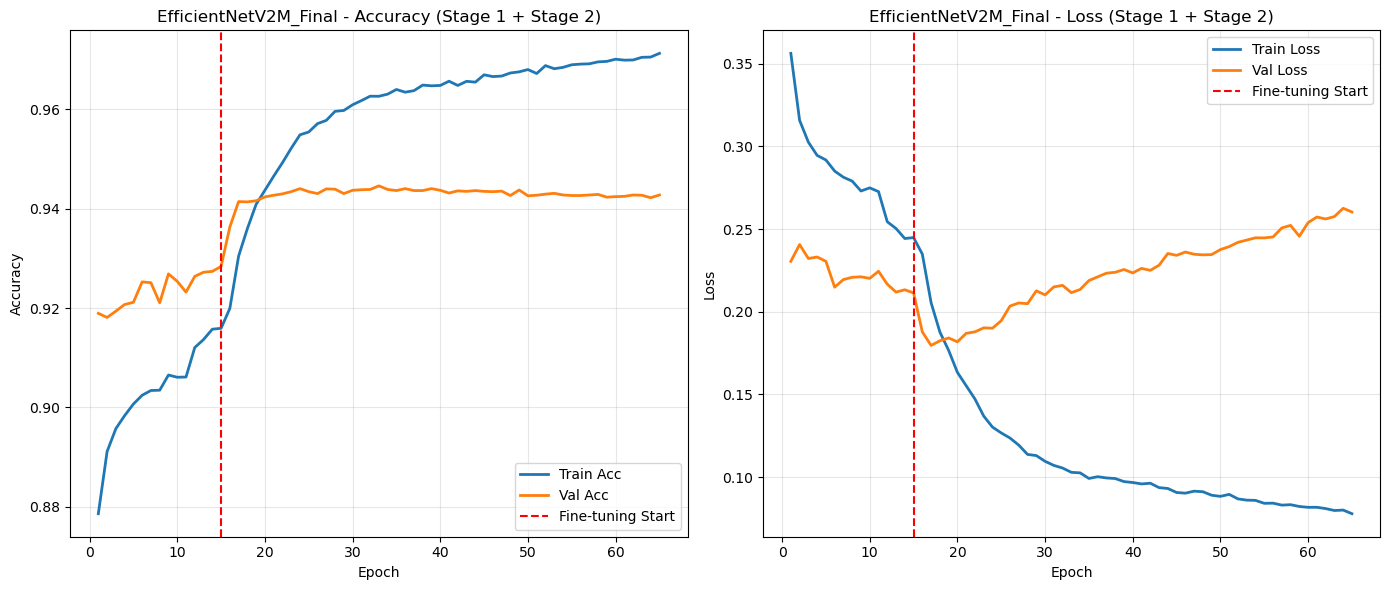

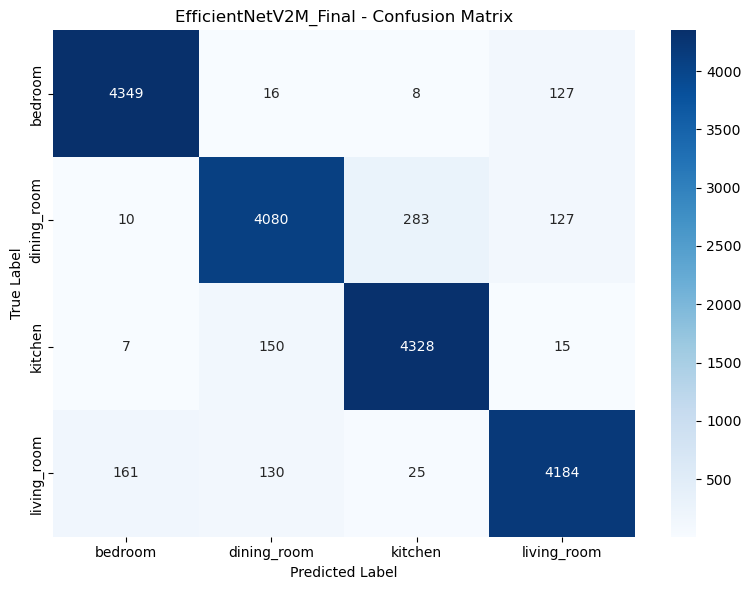


FINAL RESULTS SUMMARY
Model: EfficientNetV2M_Final (EfficientNetV2M Fine-Tuned)
Test Set Accuracy: 0.9412 (94.12%)
Test Set Loss: 0.2197


In [11]:
# ---------------------------
# EVALUATION & VISUALIZATION FUNCTIONS (Copy/Paste Entire Block)
# ---------------------------

def evaluate_model(model, test_gen, model_name='model'):
    """Evaluates model on the test set and returns metrics/results."""
    print(f"\n{'='*80}")
    print(f"EVALUATING: {model_name} on Test Set")
    print(f"{'='*80}")
    
    test_gen.reset() # Reset generator to ensure results are accurate
    
    # 1. Evaluate metrics
    # Note: We use the original test_gen (BATCH_SIZE=16) since the batch size doesn't matter for evaluation
    test_loss, test_accuracy = model.evaluate(test_gen, verbose=1)
    
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # 2. Predict for classification report/confusion matrix
    print("\nGenerating predictions for classification metrics...")
    
    # Calculate steps for prediction
    steps = math.ceil(test_gen.samples / test_gen.batch_size)
    y_pred = model.predict(test_gen, steps=steps, verbose=1)
    
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_gen.classes
    
    class_names = list(test_gen.class_indices.keys())
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_classes, 
                                   target_names=class_names, 
                                   digits=4,
                                   zero_division=0))

    cm = confusion_matrix(y_true, y_pred_classes)
    
    return test_accuracy, test_loss, y_true, y_pred_classes, cm, class_names

def plot_training_history(history, history_stage1, model_name='Model'):
    """Plots combined Stage 1 and Stage 2 training history."""
    
    # Combine histories
    # history_stage1 is from Block 5
    # history is the history_stage2 object from the last run
    acc = history_stage1.history['accuracy'] + history.history['accuracy']
    val_acc = history_stage1.history['val_accuracy'] + history.history['val_accuracy']
    loss = history_stage1.history['loss'] + history.history['loss']
    val_loss = history_stage1.history['val_loss'] + history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    plt.figure(figsize=(14, 6))
    
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train Acc', linewidth=2)
    plt.plot(epochs, val_acc, label='Val Acc', linewidth=2)
    plt.axvline(x=len(history_stage1.history['accuracy']), color='r', linestyle='--', label='Fine-tuning Start')
    plt.title(f'{model_name} - Accuracy (Stage 1 + Stage 2)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train Loss', linewidth=2)
    plt.plot(epochs, val_loss, label='Val Loss', linewidth=2)
    plt.axvline(x=len(history_stage1.history['loss']), color='r', linestyle='--', label='Fine-tuning Start')
    plt.title(f'{model_name} - Loss (Stage 1 + Stage 2)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{model_name}_history.png', dpi=150, bbox_inches='tight')
    plt.show()

def plot_confusion_matrix(cm, class_names, model_name='Model'):
    """Plots the confusion matrix using seaborn."""
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, 
                yticklabels=class_names, cmap='Blues')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'{model_name}_confusion_matrix.png', dpi=150, bbox_inches='tight')
    plt.show()

# ---------------------------
# EXECUTION
# ---------------------------

# Get the final test generator (original batch size 16)
# Note: We need to re-create it as the train_gen, val_gen, test_gen from Block 3 were overwritten 
# by the smaller batch size generators in Block 6.

# Since we don't need augmentation on test set, we just use the default Image Data Generator
test_datagen_final = ImageDataGenerator()
test_gen_final = test_datagen_final.flow_from_directory(
    os.path.join(organized_data_path, 'test'), 
    target_size=(IMG_SIZE, IMG_SIZE), 
    batch_size=BATCH_SIZE, # Use original BATCH_SIZE=16 for evaluation performance
    class_mode='categorical', 
    shuffle=False
)

MODEL_NAME_FINAL = 'EfficientNetV2M_Final'

# Stage 7.1: Evaluate on Test Set
test_acc, test_loss, y_true, y_pred_classes, cm, class_names = evaluate_model(
    model_v2m_fine_tuned, 
    test_gen_final, 
    MODEL_NAME_FINAL
)

# Stage 7.2: Plot History (Requires both history objects)
print("\nPlotting Combined Training History...")
plot_training_history(history_stage2, history_stage1, MODEL_NAME_FINAL) # Use the correct history objects

# Stage 7.3: Plot Confusion Matrix
plot_confusion_matrix(cm, class_names, MODEL_NAME_FINAL)

print("\n" + "="*80)
print("FINAL RESULTS SUMMARY")
print(f"Model: {MODEL_NAME_FINAL} (EfficientNetV2M Fine-Tuned)")
print(f"Test Set Accuracy: {test_acc:.4f} ({test_acc * 100:.2f}%)")
print(f"Test Set Loss: {test_loss:.4f}")
print("="*80)

In [15]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetV2M
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as efficientnet_v2_preprocess
from PIL import Image
import os
import time

# --- CONFIGURATION (MUST MATCH TRAINING) ---
IMG_SIZE = 384 
NUM_CLASSES = 4 
MODEL_WEIGHTS_PATH = 'EfficientNetV2M_Stage2_FineTuned_best.keras'
IMAGE_PATH = 'Kitchen_1.jpg' 
CLASS_NAMES = ['bedroom', 'dining_room', 'kitchen', 'living_room'] 
# -------------------------------------------

def create_efficientnet_v2m_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES):
    """
    Recreates the final model structure (unfrozen, with custom head) 
    so weights can be loaded correctly.
    """
    # 1. Load the pre-trained backbone (include_top=False)
    # We must load the base model with the same parameters it had when the weights were saved.
    base_model = EfficientNetV2M(
        include_top=False,            
        weights=None, # Set to None, as we load saved weights immediately after
        input_shape=input_shape
    )
    
    # Crucially, the model must be created as fully trainable to match the saved structure
    base_model.trainable = True 
    
    # 2. Define the full model architecture
    inputs = layers.Input(shape=input_shape)
    
    # EfficientNetV2 preprocessing layer
    x = efficientnet_v2_preprocess(inputs)
    
    # Pass the preprocessed input to the base model
    # Use training=False for inference (important for BatchNormalization layers)
    x = base_model(x, training=False) 
    
    # 3. Recreate the custom classification head exactly
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    
    # Final output layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs, name='EfficientNetV2M_Custom')
    
    return model

def predict_single_image(image_path, model_path, class_names):
    """Loads model, predicts image class, and prints results."""
    
    if not os.path.exists(model_path):
        print(f"❌ Error: Model weights not found at: {model_path}")
        return
        
    if not os.path.exists(image_path):
        print(f"❌ Error: Image file not found at: {image_path}")
        return

    # --- 1. Model Setup and Weight Loading ---
    print(f"1. Creating model structure and loading weights from {model_path}...")
    model = create_efficientnet_v2m_model()
    try:
        model.load_weights(model_path)
        print("   ✅ Model structure recreated and weights loaded successfully.")
    except Exception as e:
        print(f"   ❌ Error loading weights. Check model architecture configuration: {e}")
        return

    # --- 2. Image Loading and Preprocessing ---
    print(f"2. Loading and preprocessing image: {image_path}...")
    try:
        img = Image.open(image_path).convert('RGB')
        img = img.resize((IMG_SIZE, IMG_SIZE))
        img_array = np.array(img, dtype=np.float32)
        # Add batch dimension: (H, W, C) -> (1, H, W, C)
        img_array = np.expand_dims(img_array, axis=0) 
        
        print(f"   Image array shape: {img_array.shape}")
        
    except Exception as e:
        print(f"   ❌ Error processing image: {e}")
        return

    # --- 3. Prediction ---
    print("3. Making prediction...")
    start_time = time.time()
    
    # Use the model directly for inference
    predictions = model.predict(img_array) 
    
    elapsed_time = time.time() - start_time
    
    # --- 4. Interpretation ---
    predicted_class_index = np.argmax(predictions[0])
    predicted_class_name = class_names[predicted_class_index]
    confidence = predictions[0][predicted_class_index]
    
    print("4. Prediction Results:")
    print("-" * 30)
    print(f"  Predicted Class: **{predicted_class_name}**")
    print(f"  Confidence: {confidence * 100:.2f}%")
    print(f"  Inference Time: {elapsed_time:.3f} seconds")
    print("-" * 30)
    
    # Optional: print all probabilities
    print("\nAll Class Probabilities:")
    for i, name in enumerate(class_names):
        print(f"  {name:15}: {predictions[0][i] * 100:.2f}%")

# Execute the function
predict_single_image(IMAGE_PATH, MODEL_WEIGHTS_PATH, CLASS_NAMES)

1. Creating model structure and loading weights from EfficientNetV2M_Stage2_FineTuned_best.keras...
   ✅ Model structure recreated and weights loaded successfully.
2. Loading and preprocessing image: Kitchen_1.jpg...
   Image array shape: (1, 384, 384, 3)
3. Making prediction...
1/1 [==============================] - 4s 4s/step
4. Prediction Results:
------------------------------
  Predicted Class: **kitchen**
  Confidence: 83.05%
  Inference Time: 4.013 seconds
------------------------------

All Class Probabilities:
  bedroom        : 0.02%
  dining_room    : 16.89%
  kitchen        : 83.05%
  living_room    : 0.04%


In [16]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2M
from tensorflow.keras import models, layers
# Import your model creation function (assuming it's still defined)
# from the previous code blocks
# Assuming the model object is still in memory: model_v2m_fine_tuned

# --- Configuration for Saving ---
IMG_SIZE = 384
NUM_CLASSES = 4
OLD_WEIGHTS_FILE = 'EfficientNetV2M_Stage2_FineTuned_best.keras'
NEW_WEIGHTS_FILE = 'EfficientNetV2M_Stage2_FineTuned_best.h5'
# ---

print("Attempting to load problematic .keras file to save as robust .h5...")

# 1. Recreate the exact model structure
def create_minimal_model_for_loading():
    base_model = EfficientNetV2M(include_top=False, weights=None, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = True
    
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    # Note: Skipping the preprocessing layer here for minimal model recreation
    x = base_model(inputs, training=False)
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy')
    return model

export_model = create_minimal_model_for_loading()

try:
    # 2. Load the best weights from the checkpoint that was saved
    export_model.load_weights(OLD_WEIGHTS_FILE)
    
    # 3. Save the weights in the universal HDF5 format
    export_model.save_weights(NEW_WEIGHTS_FILE)
    print(f"✅ Success! Weights exported to {NEW_WEIGHTS_FILE}. Use this file for testing.")
    
except Exception as e:
    print(f"❌ Critical Error: Could not load the original checkpoint. You may need to restart the notebook and use the in-memory model object from Block 10.")

Attempting to load problematic .keras file to save as robust .h5...
✅ Success! Weights exported to EfficientNetV2M_Stage2_FineTuned_best.h5. Use this file for testing.


In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetV2M
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as efficientnet_v2_preprocess

# --- 1. Configuration ---
IMG_SIZE = 384  # EfficientNetV2M uses 384x384
NUM_CLASSES = 4
CLASS_LABELS = ['bedroom', 'dining_room', 'kitchen', 'living_room']
# Path to your best saved weights (Using the .h5 file we created)
WEIGHTS_PATH = 'EfficientNetV2M_Stage2_FineTuned_best.h5' 

# --- 2. Function to Reconstruct Model and Load Weights ---
def load_trained_model(weights_path):
    print(f"🏗️ Reconstructing EfficientNetV2M architecture...")
    
    # 1. Build Base
    base_model = EfficientNetV2M(
        include_top=False,
        weights=None, 
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    base_model.trainable = True 
    
    # 2. Build Head (Must match training structure exactly)
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Preprocessing is part of the model here
    x = efficientnet_v2_preprocess(inputs) 
    x = base_model(x, training=False) 
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = models.Model(inputs, outputs, name='EfficientNetV2M_Custom')
    
    # 3. Load Weights
    print(f"📂 Loading weights from: {weights_path}")
    if os.path.exists(weights_path):
        model.load_weights(weights_path)
        print("✅ Weights loaded successfully.")
    else:
        raise FileNotFoundError(f"❌ Weights file not found at: {weights_path}")
        
    return model

# --- 3. Prediction Function ---
def predict_image(image_path, model):
    """
    Loads an image, predicts class, and visualizes result.
    """
    try:
        # Load and Resize
        img = image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
        
        # Convert to Array
        img_array = image.img_to_array(img)
        img_batch = np.expand_dims(img_array, axis=0)
        
        # Note: We do NOT divide by 255.0 here because 'efficientnet_v2_preprocess'
        # inside the model handles the scaling automatically.
        
        # Predict
        predictions = model.predict(img_batch, verbose=0)
        predicted_class_idx = np.argmax(predictions)
        confidence = np.max(predictions)
        predicted_label = CLASS_LABELS[predicted_class_idx]
        
        # Visualize (Exactly like your example)
        plt.figure(figsize=(6, 6))
        plt.imshow(image.load_img(image_path)) # Reload to show original aspect ratio if desired
        plt.axis('off')
        plt.title(f"Pred: {predicted_label.upper()} ({confidence*100:.2f}%)")
        plt.show()
        
        print(f"✅ Prediction: {predicted_label}")
        print(f"📊 Confidence Scores: {dict(zip(CLASS_LABELS, np.round(predictions[0], 4)))}")
        
    except Exception as e:
        print(f"⚠️ Error processing image: {e}")

🏗️ Reconstructing EfficientNetV2M architecture...
📂 Loading weights from: EfficientNetV2M_Stage2_FineTuned_best.h5
✅ Weights loaded successfully.


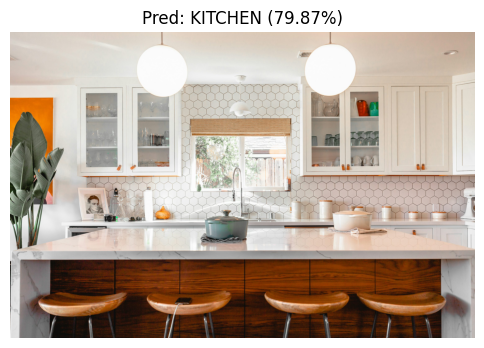

✅ Prediction: kitchen
📊 Confidence Scores: {'bedroom': np.float32(0.0), 'dining_room': np.float32(0.2013), 'kitchen': np.float32(0.7987), 'living_room': np.float32(0.0)}


In [13]:
# ==========================================
# MAIN EXECUTION
# ==========================================
TEST_IMAGE_PATH = "Kitchen_1.jpg"
try:
    # 1. Load the model
    model_inference = load_trained_model(WEIGHTS_PATH)
    
    # 2. Example Usage
    if os.path.exists(TEST_IMAGE_PATH):
        predict_image(TEST_IMAGE_PATH, model_inference)
    else:
        print(f"❌ Test image not found at: {TEST_IMAGE_PATH}")

except Exception as e:
    print(f"\n❌ Setup Failed: {e}")